---
# Recovery Forecasting for Level 3 Industries in TX

Adam Talbot

---

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

# sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

# time series imports
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import Holt
from datetime import datetime

# pickle for reloading model object
import pickle

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
# sns.set_palette('tab20')
plt.style.use('seaborn-darkgrid')

# custom modules
import wrangle as w
import explore as e

---
## Wrangle
---

In [2]:
# get dictionary with all industries
# get all monthly data
df = w.get_tx_forecasting_data()
# subset data into a dictionary of dfs
industry_df_dict, ind_list = w.create_df_dict_forecasting(df)

In [3]:
# list of industries I will forecast
forecast_ind_list = [
    'Performing Arts, Spectator Sports, and Related Industries',
    'Miscellaneous Store Retailers ',
    'Sporting Goods, Hobby, Musical Instrument, and Book Stores ',
    'Accommodation',
    'Food Services and Drinking Places',
    'Motion Picture and Sound Recording Industries',
    'Personal and Laundry Services',
    'Furniture and Home Furnishings Stores ',
    'Leather and Allied Product Manufacturing',
    'Amusement, Gambling, and Recreation Industries',
    'Scenic and Sightseeing Transportation',
    'Clothing and Clothing Accessories Stores '
]

In [4]:
# create dictionary of dfs for these industries
forecast_ind_dict = {}
for ind in forecast_ind_list:
    forecast_ind_dict[ind] = industry_df_dict[ind]

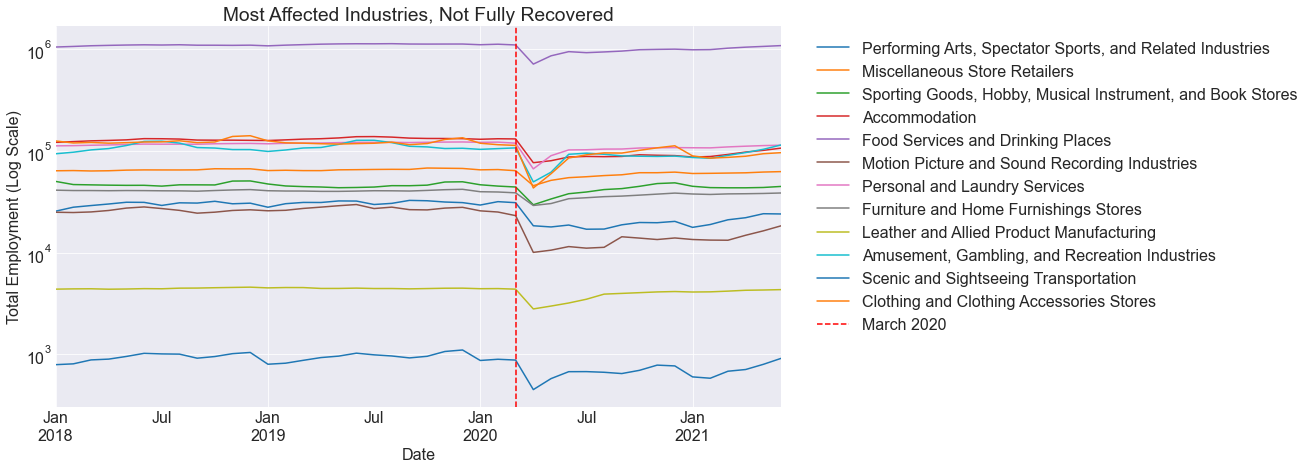

In [5]:
# take a look at industries
for ind in forecast_ind_list:
    forecast_ind_dict[ind]['2018' : ].plot(label=ind)
plt.gca().set(ylabel = 'Total Employment (Log Scale)', title='Most Affected Industries, Not Fully Recovered')
plt.gca().axvline(x='2020-03', color = 'red', linestyle = '--', label='March 2020')
plt.yscale('log')
plt.legend(bbox_to_anchor= (1.03,1))
plt.show()

---
## Forecast
---

### Motion Picture and Sound Recording Industries
---

#### Plot

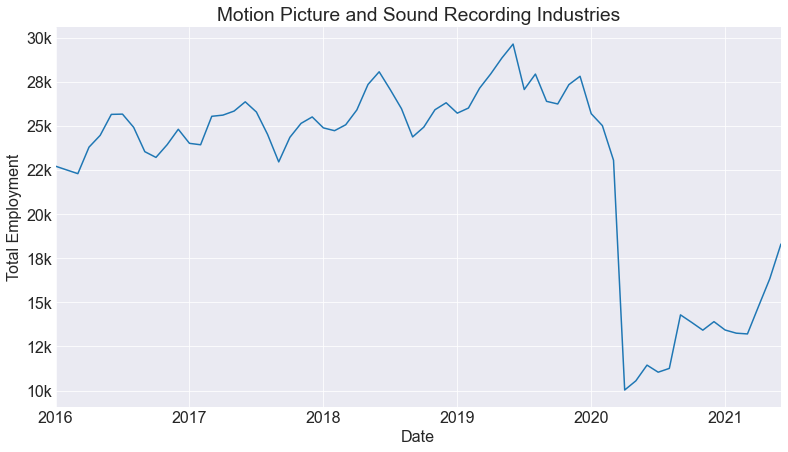

In [6]:
# plot series
s_motion = forecast_ind_dict['Motion Picture and Sound Recording Industries']
s_motion.plot()
plt.gca().set(ylabel = 'Total Employment', title='Motion Picture and Sound Recording Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

#### Recovery

In [7]:
# find min value where employment bottomed out and recovery started
s_motion[s_motion == s_motion.min()]

Date
2020-04-01    10034
Name: Total Employment, dtype: int64

In [8]:
# define train set for this model
train = s_motion['2020-04' : ]

In [9]:
# Holts model
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    ]

future_index = pd.to_datetime(future_index_str)

holts = model.predict(start = future_index[0], end = future_index[-1])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Resumption

In [10]:
train = s_motion['2016' : '2018']
test = s_motion['2019']

In [11]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

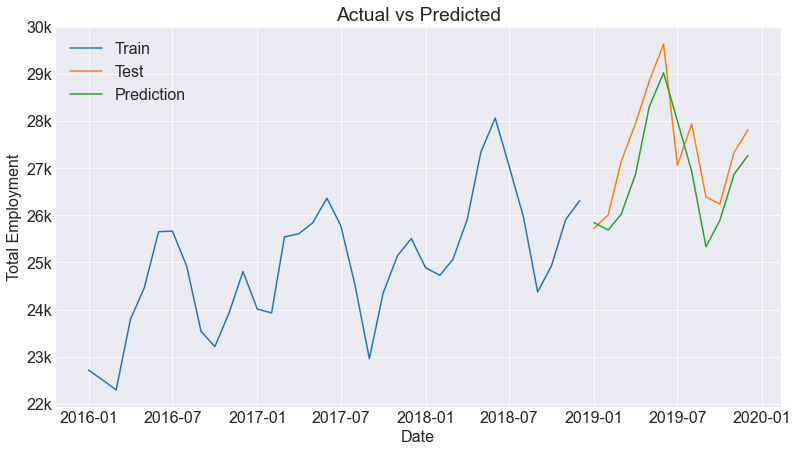

In [12]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [13]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

755.7787110453997

In [14]:
# get R^2
explained_variance_score(test, forecast)

0.7461388782842269

In [15]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_motion['2018-08' : '2019-12']

In [16]:
# get index for seasonal prediction
future_index_str = [
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11', 
    '2023-12', 
    '2024-01', 
    '2024-02', 
    '2024-03',
    '2024-04',
    '2024-05',
    '2024-06',
    '2024-07',
    '2024-08',
    '2024-09',
    '2024-10',
    '2024-11',
    '2024-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [17]:
# make predictions
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

#### Final Plot

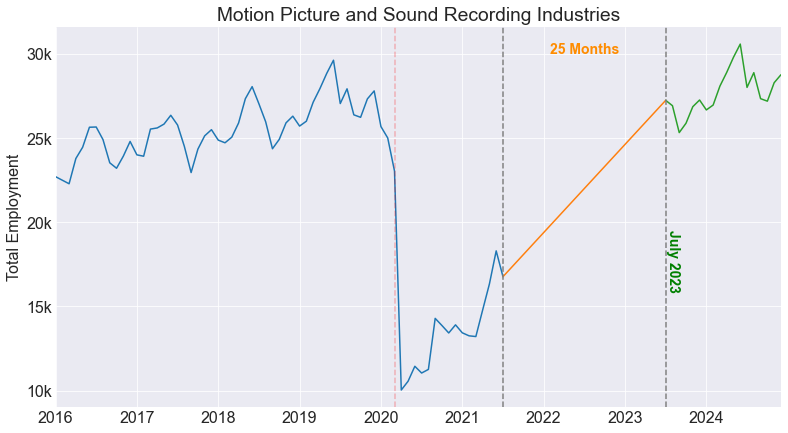

In [18]:
full_forecast = pd.concat([s_motion, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2023-07'].plot() # linear recovery forecast
full_forecast['2023-07' : ].plot() # resumption forecast
plt.gca().axvline(x='2021-07', linestyle='--', color='gray')
plt.gca().axvline(x='2023-07', linestyle='--', color='gray')
plt.gca().axvline(x='2020-03', linestyle='--', color='red', alpha=0.25)
plt.text('2022-02', 30_000, '25 Months', fontsize=14, color='darkorange', fontweight='bold')
plt.text('2023-07', 16_000, 'July 2023', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set(title='Motion Picture and Sound Recording Industries', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
### Performing Arts, Spectator Sports, and Related Industries
---

#### Plot

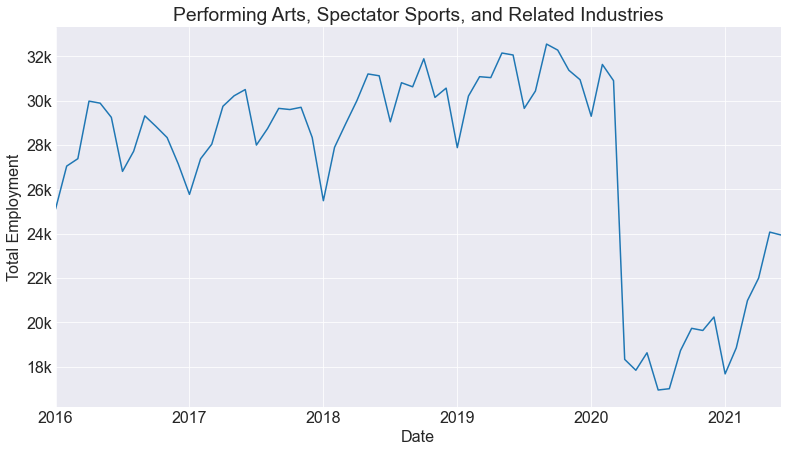

In [19]:
# plot series
s_perform = forecast_ind_dict['Performing Arts, Spectator Sports, and Related Industries']
s_perform.plot()
plt.gca().set(ylabel = 'Total Employment', title='Performing Arts, Spectator Sports, and Related Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

#### Recovery

In [20]:
# find min value where employment bottomed out and recovery started
s_perform[s_perform == s_perform.min()]

Date
2020-07-01    16953
Name: Total Employment, dtype: int64

In [21]:
# define train set for this model
train = s_perform['2020-07' : ]

In [22]:
# Holts model
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10'
    ]

future_index = pd.to_datetime(future_index_str)

holts = model.predict(start = future_index[0], end = future_index[-1])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Resumption

In [23]:
train = s_perform['2016' : '2018']
test = s_perform['2019']

In [24]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

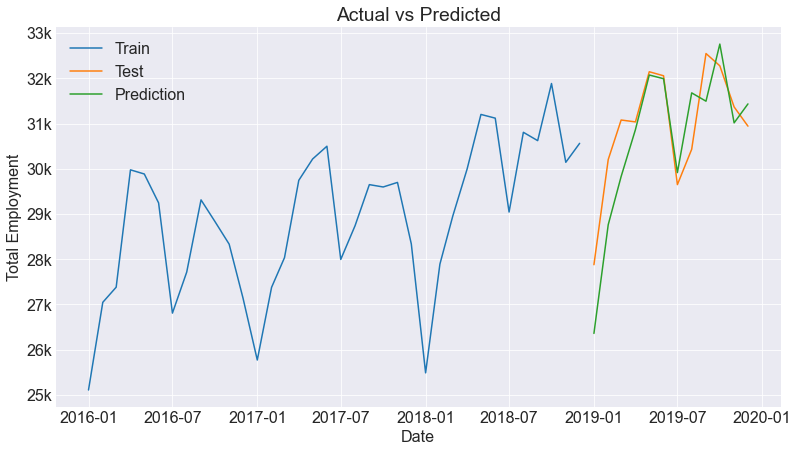

In [25]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [26]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

881.1867353177759

In [27]:
# get R^2
explained_variance_score(test, forecast)

0.5640463943798542

In [28]:
# predict the future
historical = s_perform['2018-11' : '2019-12']

In [29]:
# get index for seasonal prediction
future_index_str = [
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [30]:
# make predictions
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

#### Final Plot

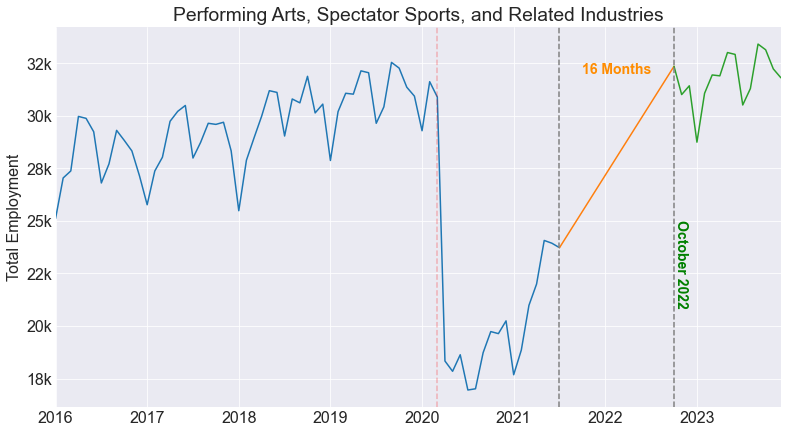

In [31]:
full_forecast = pd.concat([s_perform, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-10'].plot() # linear recovery forecast
full_forecast['2022-10' : ].plot() # resumption forecast
plt.gca().axvline(x='2021-07', linestyle='--', color='gray')
plt.gca().axvline(x='2022-10', linestyle='--', color='gray')
plt.gca().axvline(x='2020-03', linestyle='--', color='red', alpha=0.25)
plt.text('2021-10', 32_000, '16 Months', fontsize=14, color='darkorange', fontweight='bold')
plt.text('2022-10', 21_000, 'October 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set(title='Performing Arts, Spectator Sports, and Related Industries', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
### Accommodation
---

#### Plot

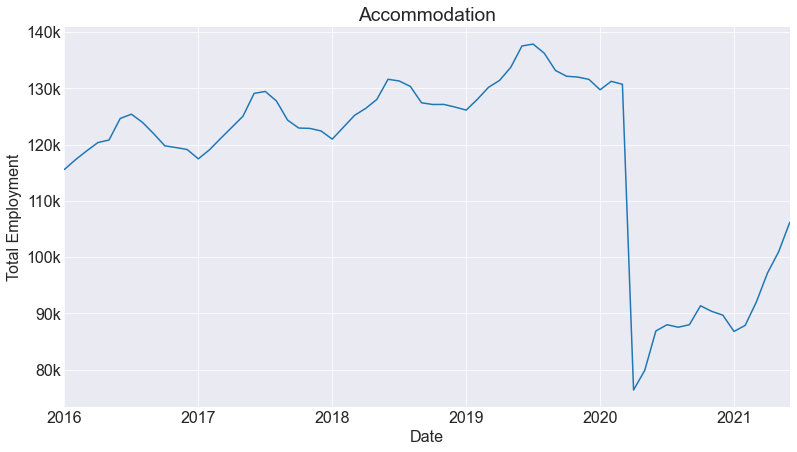

In [32]:
# plot series
s_accom = forecast_ind_dict['Accommodation']
s_accom.plot()
plt.gca().set(ylabel = 'Total Employment', title='Accommodation')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

#### Recovery

In [33]:
# find min value where employment bottomed out and recovery started
s_accom[s_accom == s_accom.min()]

Date
2020-04-01    76362
Name: Total Employment, dtype: int64

In [34]:
# define train set for this model
train = s_accom['2020-04' : ]

In [35]:
# Holts model
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    ]

future_index = pd.to_datetime(future_index_str)

holts = model.predict(start = future_index[0], end = future_index[-1])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Resumption

In [36]:
train = s_accom['2016' : '2018']
test = s_accom['2019']

In [37]:
forecast = train['2018'] + 2*(train.diff(12).mean())
forecast.index = test.index

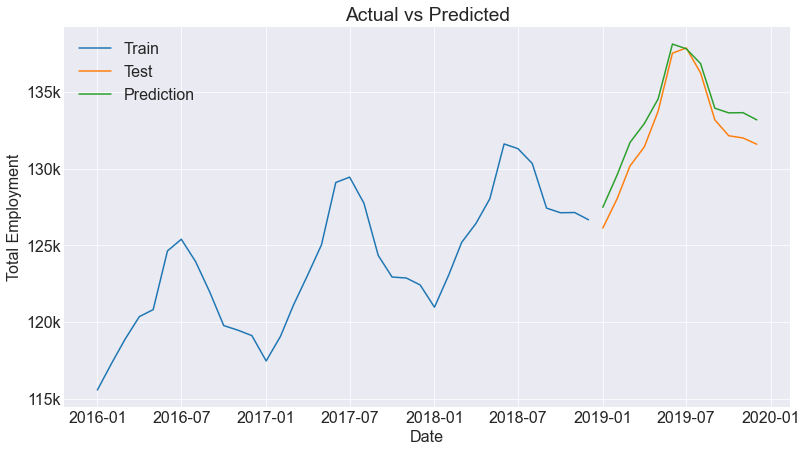

In [38]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [39]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

1234.7828081623638

In [40]:
# get R^2
explained_variance_score(test, forecast)

0.9757237200256674

In [41]:
# predict the future
historical = s_accom['2018-09' : '2019-12']

In [42]:
# get index for seasonal prediction
future_index_str = [
    '2023-09',
    '2023-10',
    '2023-11', 
    '2023-12', 
    '2024-01', 
    '2024-02', 
    '2024-03',
    '2024-04',
    '2024-05',
    '2024-06',
    '2024-07',
    '2024-08',
    '2024-09',
    '2024-10',
    '2024-11',
    '2024-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [43]:
# make predictions
future = historical + 2*(train.diff(12).mean())
# still need to reset the index
future.index = future_index

#### Final Plot

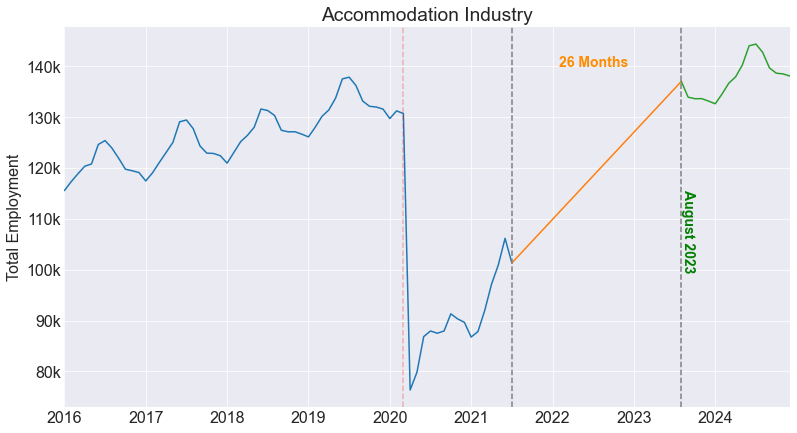

In [44]:
full_forecast = pd.concat([s_accom, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2023-08'].plot() # linear recovery forecast
full_forecast['2023-08' : ].plot() # resumption forecast
plt.gca().axvline(x='2021-07', linestyle='--', color='gray')
plt.gca().axvline(x='2023-08', linestyle='--', color='gray')
plt.gca().axvline(x='2020-03', linestyle='--', color='red', alpha=0.25)
plt.text('2022-02', 140_000, '26 Months', fontsize=14, color='darkorange', fontweight='bold')
plt.text('2023-08', 100_000, 'August 2023', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Accommodation Industry', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
### Clothing and Clothing Accessories Stores
---

#### Plot

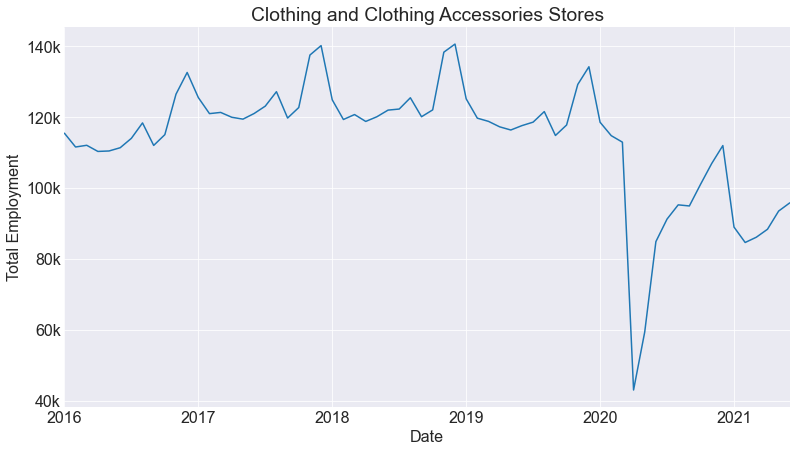

In [45]:
# plot series
s_cloth = forecast_ind_dict['Clothing and Clothing Accessories Stores ']
s_cloth.plot()
plt.gca().set(ylabel = 'Total Employment', title='Clothing and Clothing Accessories Stores')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

#### Recovery

In [46]:
# find min value where employment bottomed out and recovery started
s_cloth[s_cloth == s_cloth.min()]

Date
2020-04-01    43098
Name: Total Employment, dtype: int64

In [47]:
# define train set for this model
train = s_cloth['2020-04' : ]

In [48]:
# Holts model
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03'
    ]

future_index = pd.to_datetime(future_index_str)

holts = model.predict(start = future_index[0], end = future_index[-1])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Resumption

In [49]:
train = s_cloth['2016' : '2018']
test = s_cloth['2019']

In [50]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

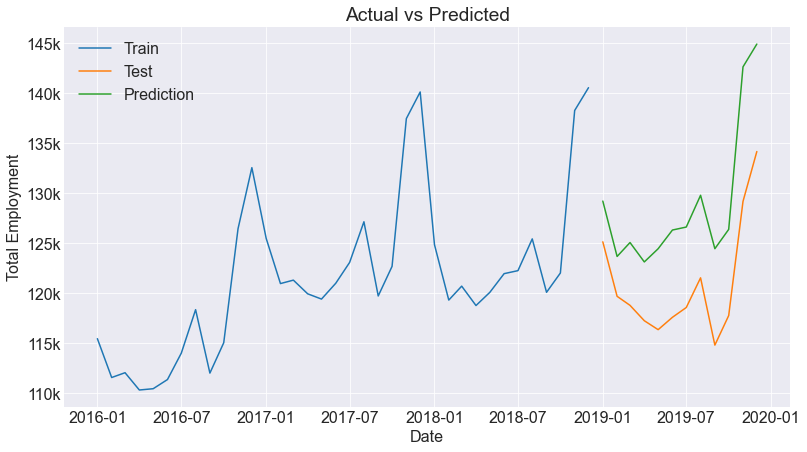

In [51]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [52]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

8395.442380889366

In [53]:
# get R^2
explained_variance_score(test, forecast)

0.7815896780786884

In [54]:
# predict the future
historical = s_cloth['2018-04' : '2019-12']

In [55]:
# get index for seasonal prediction
future_index_str = [
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [56]:
# make predictions
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

#### Final Plot

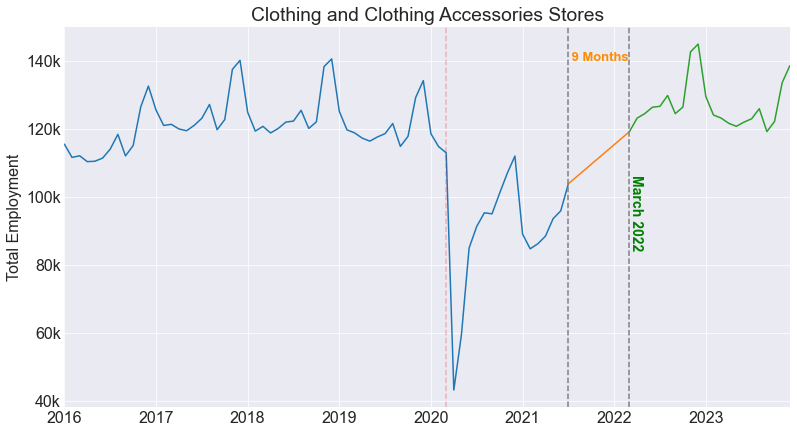

In [57]:
full_forecast = pd.concat([s_cloth, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-03'].plot() # linear recovery forecast
full_forecast['2022-03' : ].plot() # resumption forecast
plt.gca().axvline(x='2021-07', linestyle='--', color='gray')
plt.gca().axvline(x='2022-03', linestyle='--', color='gray')
plt.gca().axvline(x='2020-03', linestyle='--', color='red', alpha=0.25)
plt.text('2021-07', 140_000, ' 9 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2022-03', 85_000, 'March 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Clothing and Clothing Accessories Stores', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
### Scenic and Sightseeing Transportation
---

#### Plot

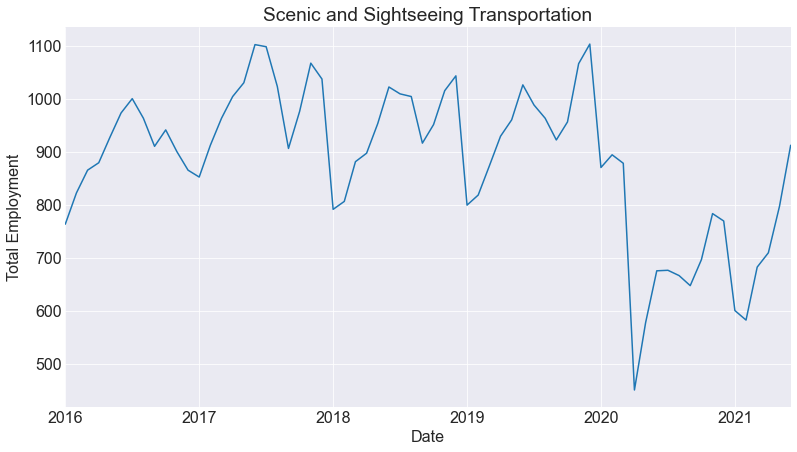

In [58]:
# plot series
s_scene = forecast_ind_dict['Scenic and Sightseeing Transportation']
s_scene.plot()
plt.gca().set(ylabel = 'Total Employment', title='Scenic and Sightseeing Transportation');

#### Recovery

In [59]:
# find min value where employment bottomed out and recovery started
s_scene[s_scene == s_scene.min()]

Date
2020-04-01    450
Name: Total Employment, dtype: int64

In [60]:
# define train set for this model
train = s_scene['2020-04' : ]

In [61]:
# Holts model
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04', 
    '2022-05', 
    '2022-06', 
    '2022-07'
    ]

future_index = pd.to_datetime(future_index_str)

holts = model.predict(start = future_index[0], end = future_index[-1])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Resumption

In [62]:
train = s_scene['2016' : '2018']
test = s_scene['2019']

In [63]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

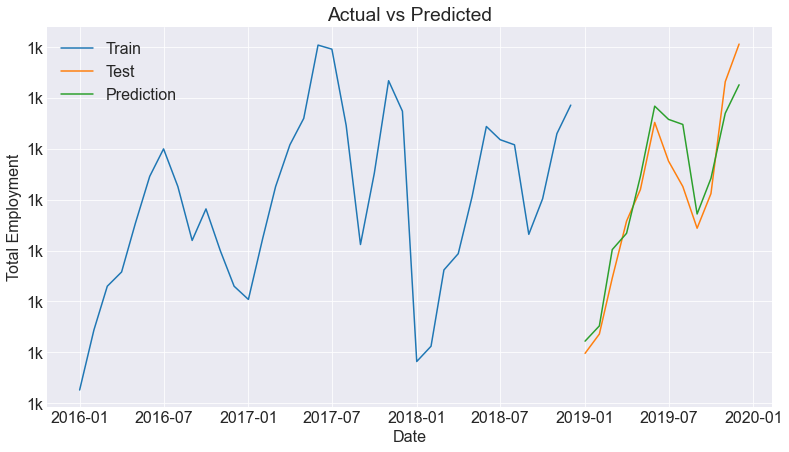

In [64]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [65]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

28.788018340969565

In [66]:
# get R^2
explained_variance_score(test, forecast)

0.9058180071357287

In [67]:
# predict the future
historical = s_scene['2018-08' : '2019-12']

In [68]:
# get index for seasonal prediction
future_index_str = [
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [69]:
# make predictions
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

#### Final Plot

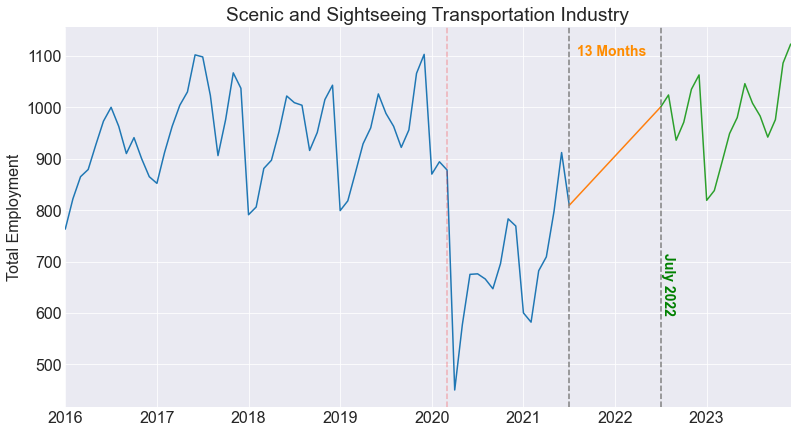

In [70]:
full_forecast = pd.concat([s_scene, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-07'].plot() # linear recovery forecast
full_forecast['2022-07' : ].plot() # resumption forecast
plt.gca().axvline(x='2021-07', linestyle='--', color='gray')
plt.gca().axvline(x='2022-07', linestyle='--', color='gray')
plt.gca().axvline(x='2020-03', linestyle='--', color='red', alpha=0.25)
plt.text('2021-08', 1100, '13 Months', fontsize=14, color='darkorange', fontweight='bold')
plt.text('2022-07', 600, 'July 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Scenic and Sightseeing Transportation Industry', ylabel='Total Employment');

---
### Amusement, Gambling, and Recreation Industries
---

#### Plot

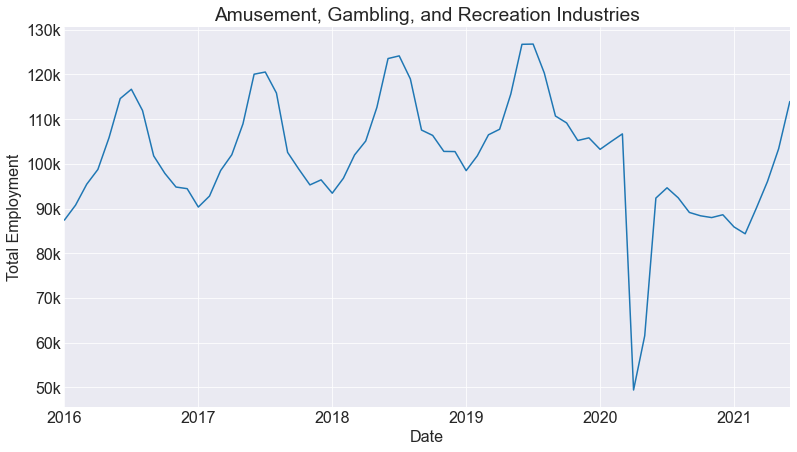

In [71]:
# plot series
s_amuse = forecast_ind_dict['Amusement, Gambling, and Recreation Industries']
s_amuse.plot()
plt.gca().set(ylabel = 'Total Employment', title='Amusement, Gambling, and Recreation Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

#### Recovery

In [72]:
# find min value where employment bottomed out and recovery started
s_amuse[s_amuse == s_amuse.min()]

Date
2020-04-01    49433
Name: Total Employment, dtype: int64

In [73]:
# define train set for this model
train = s_amuse['2020-04' : ]

In [74]:
# Holts model
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09'
    ]

future_index = pd.to_datetime(future_index_str)

holts = model.predict(start = future_index[0], end = future_index[-1])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Resumption

In [75]:
train = s_amuse['2016' : '2018']
test = s_amuse['2019']

In [76]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

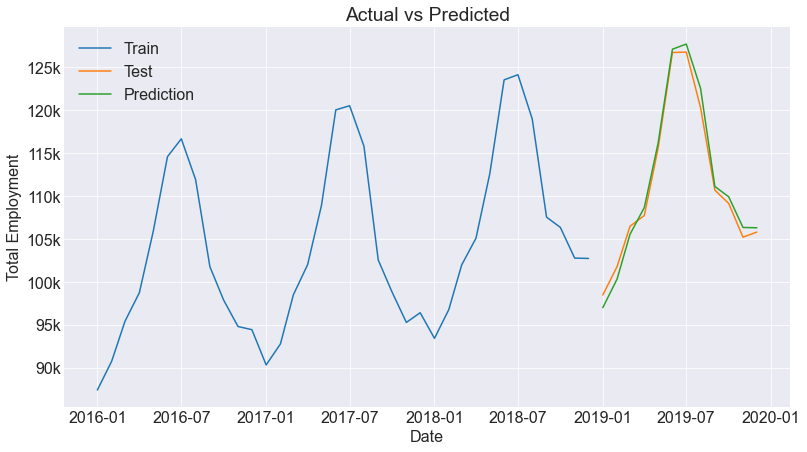

In [77]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [78]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

1109.2879042493366

In [79]:
# get R^2
explained_variance_score(test, forecast)

0.9857577001512258

In [80]:
# predict the future
historical = s_amuse['2018-10' : '2019-12']

In [81]:
# get index for seasonal prediction
future_index_str = [
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [82]:
# make predictions
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

#### Final Plot

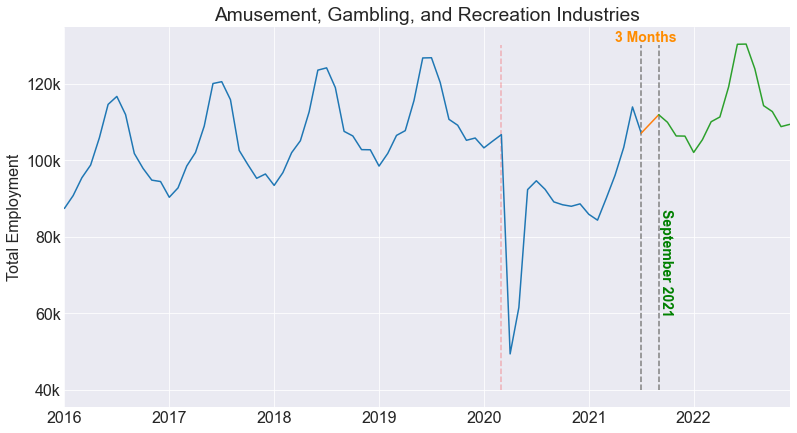

In [83]:
full_forecast = pd.concat([s_amuse, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2021-09'].plot() # linear recovery forecast
full_forecast['2021-09' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=40_000, ymax=130_000, linestyles='--', colors='gray')
plt.vlines(x='2021-09', ymin=40_000, ymax=130_000, linestyles='--', colors='gray')
plt.vlines(x='2020-03', ymin=40_000, ymax=130_000, linestyles='--', colors='red', alpha=0.25)
plt.text('2021-04', 131_000, '3 Months', fontsize=14, color='darkorange', fontweight='bold')
plt.text('2021-09', 60_000, 'September 2021', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Amusement, Gambling, and Recreation Industries', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
### Personal and Laundry Services
---

#### Plot

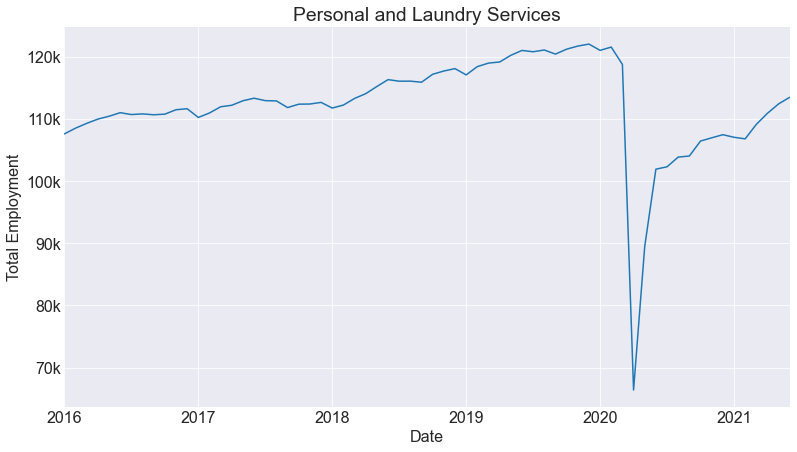

In [84]:
# plot series
s_laundry = forecast_ind_dict['Personal and Laundry Services']
s_laundry.plot()
plt.gca().set(ylabel = 'Total Employment', title='Personal and Laundry Services')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

#### Recovery

In [85]:
# find min value where employment bottomed out and recovery started
s_laundry[s_laundry == s_laundry.min()]

Date
2020-04-01    66403
Name: Total Employment, dtype: int64

In [86]:
# define train set for this model
# this slope was used since bounceback was so rapid
train = s_laundry['2020-06' : ]

In [87]:
# Holts model
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03'
    ]

future_index = pd.to_datetime(future_index_str)

holts = model.predict(start = future_index[0], end = future_index[-1])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Resumption

In [88]:
train = s_laundry['2016' : '2018']
test = s_laundry['2019']

In [89]:
forecast = train['2018'] + 2*(train.diff(12).mean())
forecast.index = test.index

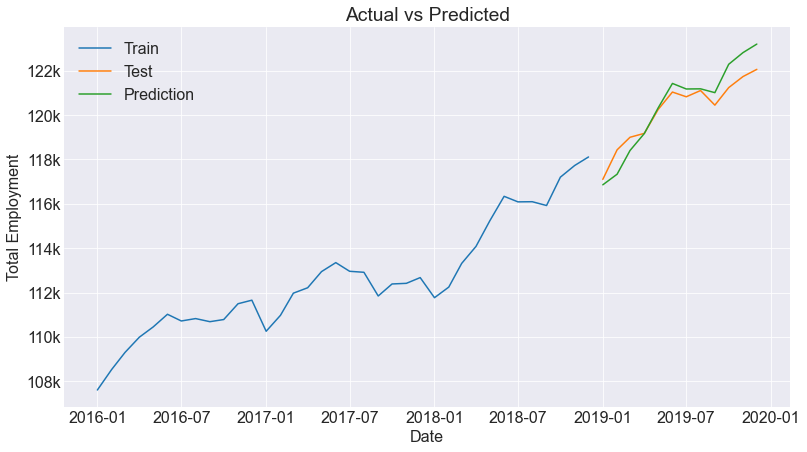

In [90]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [91]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

694.7981121640076

In [92]:
# get R^2
explained_variance_score(test, forecast)

0.7860067359422684

In [93]:
# predict the future
historical = s_laundry['2018-04' : '2019-12']

In [94]:
# get index for seasonal prediction
future_index_str = [
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [95]:
# make predictions
future = historical + 2*(train.diff(12).mean())
# still need to reset the index
future.index = future_index

#### Final Plot

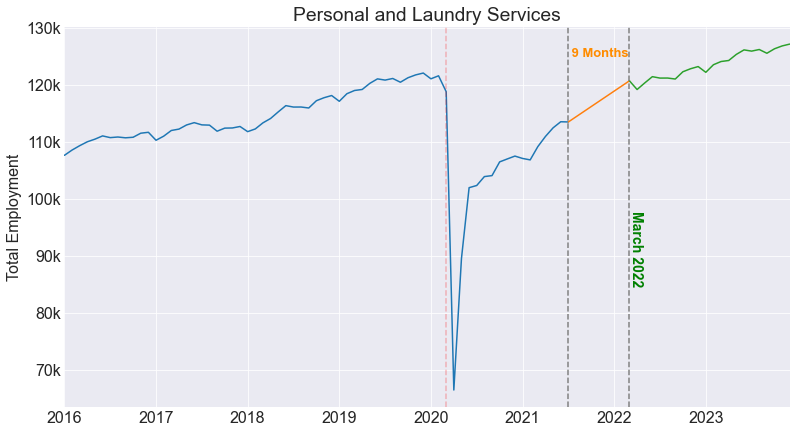

In [96]:
full_forecast = pd.concat([s_laundry, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-03'].plot() # linear recovery forecast
full_forecast['2022-03' : ].plot() # resumption forecast
plt.gca().axvline(x='2021-07', linestyle='--', color='gray')
plt.gca().axvline(x='2022-03', linestyle='--', color='gray')
plt.gca().axvline(x='2020-03', linestyle='--', color='red', alpha=0.25)
plt.text('2021-07', 125_000, ' 9 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2022-03', 85_000, 'March 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Personal and Laundry Services', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
### Miscellaneous Store Retailersand Laundry Services
---

#### Plot

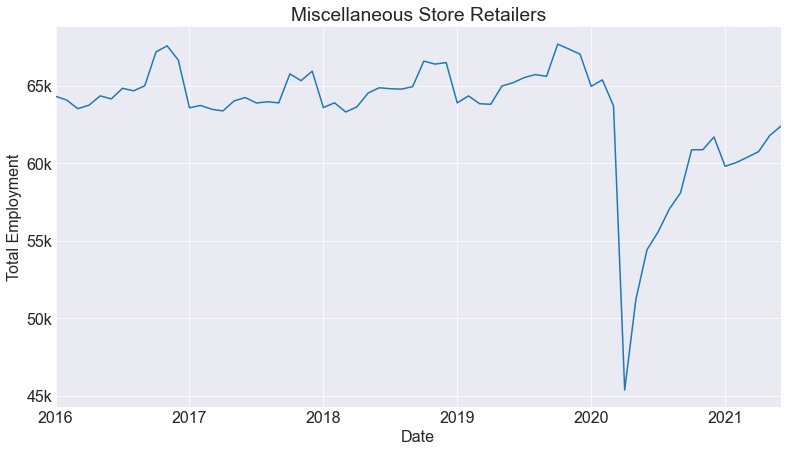

In [97]:
# plot series
s_misc = forecast_ind_dict['Miscellaneous Store Retailers ']
s_misc.plot()
plt.gca().set(ylabel = 'Total Employment', title='Miscellaneous Store Retailers')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

#### Recovery

In [98]:
# find min value where employment bottomed out and recovery started
s_misc[s_misc == s_misc.min()]

Date
2020-04-01    45385
Name: Total Employment, dtype: int64

In [99]:
# define train set for this model
# this slope was used since bounceback was so rapid
train = s_misc['2020-06' : ]

In [100]:
# Holts model
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01'
    ]

future_index = pd.to_datetime(future_index_str)

holts = model.predict(start = future_index[0], end = future_index[-1])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Resumption

In [101]:
train = s_misc['2016' : '2018']
test = s_misc['2019']

In [102]:
forecast = train['2018'] + (train.diff(12).mean())
forecast.index = test.index

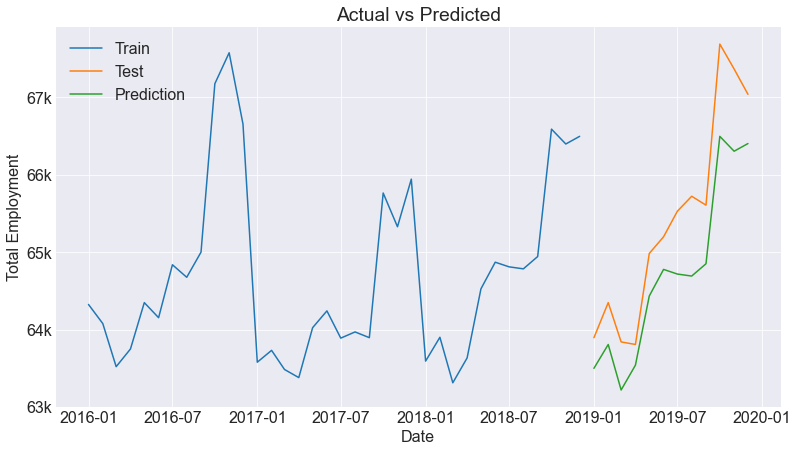

In [103]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [104]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

743.717442097841

In [105]:
# get R^2
explained_variance_score(test, forecast)

0.9554362773973608

In [106]:
# predict the future
historical = s_misc['2018-02' : '2019-12']

In [107]:
# get index for seasonal prediction
future_index_str = [
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [108]:
# make predictions
future = historical + (train.diff(12).mean())
# still need to reset the index
future.index = future_index

#### Final Plot

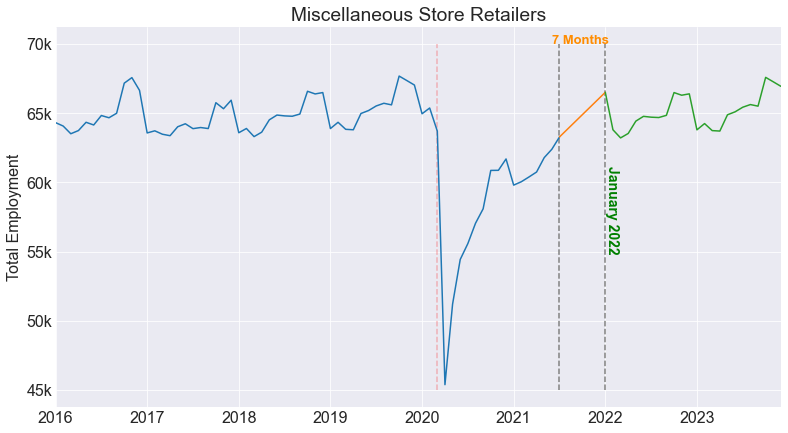

In [109]:
full_forecast = pd.concat([s_misc, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-01'].plot() # linear recovery forecast
full_forecast['2022-01' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=45_000, ymax=70_000, linestyles='--', colors='gray')
plt.vlines(x='2022-01', ymin=45_000, ymax=70_000, linestyles='--', colors='gray')
plt.vlines(x='2020-03', ymin=45_000, ymax=70_000, linestyles='--', colors='red', alpha=0.25)
plt.text('2021-06', 70_000, '7 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2022-01', 55_000, 'January 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Miscellaneous Store Retailers', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
### Furniture and Home Furnishings Stores
---

#### Plot

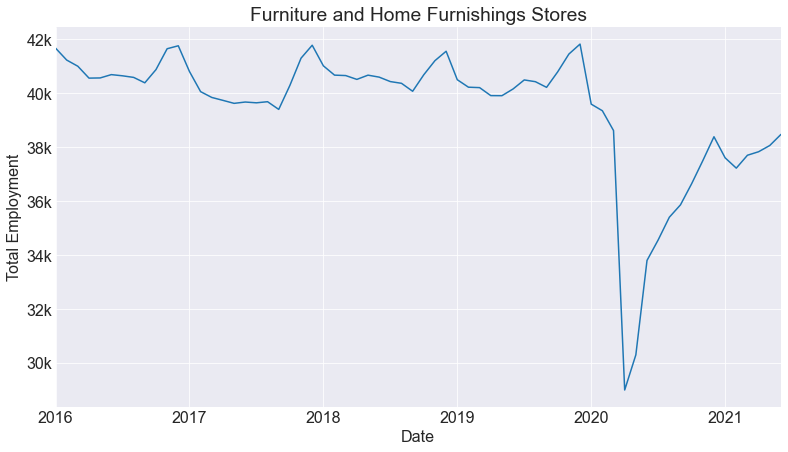

In [110]:
# plot series
s_furn = forecast_ind_dict['Furniture and Home Furnishings Stores ']
s_furn.plot()
plt.gca().set(ylabel = 'Total Employment', title='Furniture and Home Furnishings Stores')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

#### Recovery

In [111]:
# find min value where employment bottomed out and recovery started
s_furn[s_furn == s_furn.min()]

Date
2020-04-01    29002
Name: Total Employment, dtype: int64

In [112]:
# define train set for this model
# this slope was used since bounceback was so rapid
train = s_furn['2020-06' : ]

In [113]:
# Holts model
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01'
    ]

future_index = pd.to_datetime(future_index_str)

holts = model.predict(start = future_index[0], end = future_index[-1])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Resumption

In [114]:
train = s_furn['2016' : '2018']
test = s_furn['2019']

In [115]:
forecast = train['2018'] + (train.diff(12).mean())
forecast.index = test.index

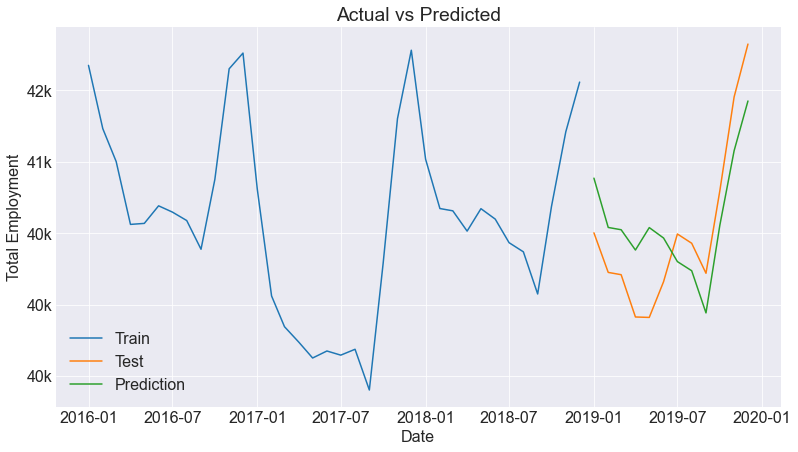

In [116]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [117]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

360.84699983741956

In [118]:
# get R^2
explained_variance_score(test, forecast)

0.6003876705014923

In [119]:
# predict the future
historical = s_furn['2018-02' : '2019-12']

In [120]:
# get index for seasonal prediction
future_index_str = [
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [121]:
# make predictions
future = historical + (train.diff(12).mean())
# still need to reset the index
future.index = future_index

#### Final Plot

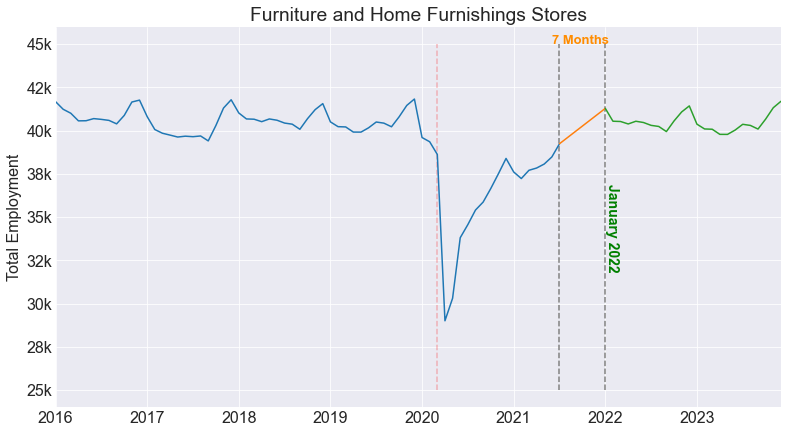

In [122]:
full_forecast = pd.concat([s_furn, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2022-01'].plot() # linear recovery forecast
full_forecast['2022-01' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=25_000, ymax=45_000, linestyles='--', colors='gray')
plt.vlines(x='2022-01', ymin=25_000, ymax=45_000, linestyles='--', colors='gray')
plt.vlines(x='2020-03', ymin=25_000, ymax=45_000, linestyles='--', colors='red', alpha=0.25)
plt.text('2021-06', 45_000, '7 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2022-01', 32_000, 'January 2022', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Furniture and Home Furnishings Stores', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
### Food Services and Drinking Places
---

#### Plot

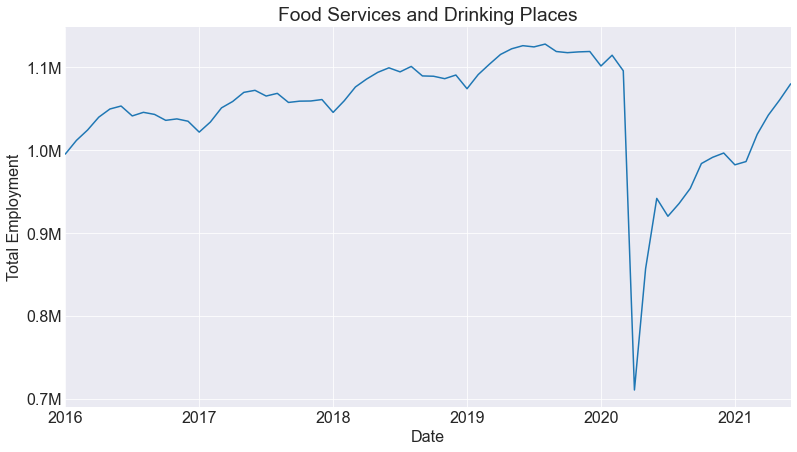

In [123]:
# plot series
s_food = forecast_ind_dict['Food Services and Drinking Places']
s_food.plot()
plt.gca().set(ylabel = 'Total Employment', title='Food Services and Drinking Places')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000));

#### Recovery

In [124]:
# find min value where employment bottomed out and recovery started
s_food[s_food == s_food.min()]

Date
2020-04-01    710703
Name: Total Employment, dtype: int64

In [125]:
# define train set for this model
# this slope was used since bounceback was so rapid
train = s_food['2020-06' : ]

In [126]:
# Holts model
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11'
    ]

future_index = pd.to_datetime(future_index_str)

holts = model.predict(start = future_index[0], end = future_index[-1])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Resumption

In [127]:
train = s_food['2016' : '2018']
test = s_food['2019']

In [128]:
forecast = train['2018'] + (train.diff(12).mean())
forecast.index = test.index

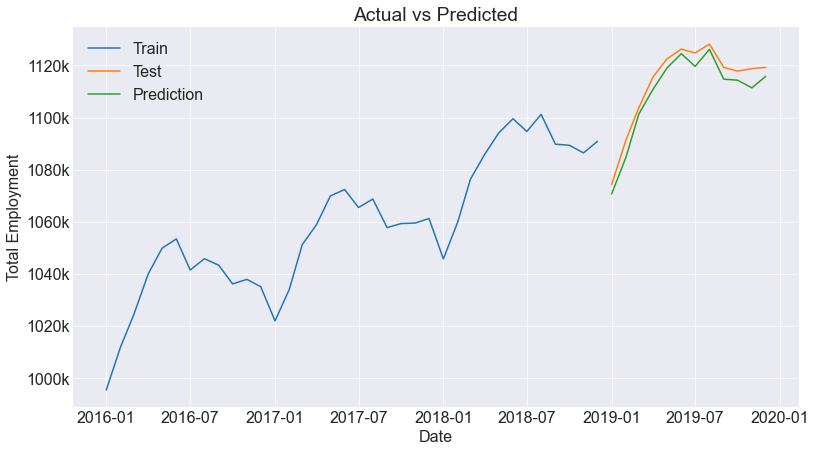

In [129]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [130]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

4369.246242679313

In [131]:
# get R^2
explained_variance_score(test, forecast)

0.9884415511610468

In [132]:
# predict the future
historical = s_food['2018-12' : '2019-12']

In [133]:
# get index for seasonal prediction
future_index_str = [
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [134]:
# make predictions
future = historical + (train.diff(12).mean())
# still need to reset the index
future.index = future_index

#### Final Plot

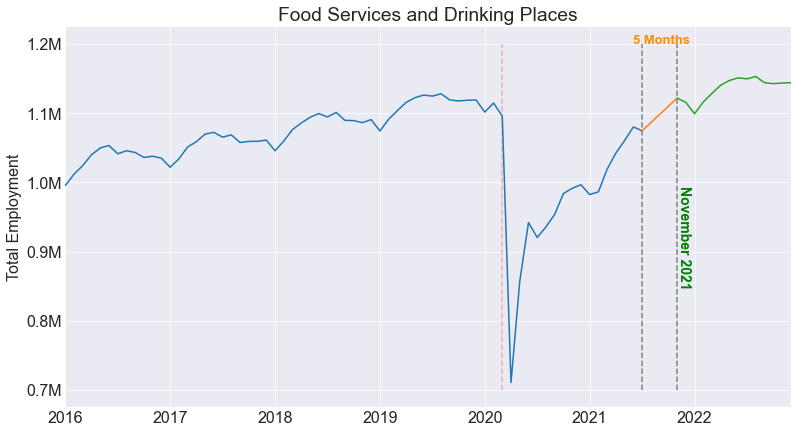

In [135]:
full_forecast = pd.concat([s_food, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2021-11'].plot() # linear recovery forecast
full_forecast['2021-11' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=700_000, ymax=1_200_000, linestyles='--', colors='gray')
plt.vlines(x='2021-11', ymin=700_000, ymax=1_200_000, linestyles='--', colors='gray')
plt.vlines(x='2020-03', ymin=700_000, ymax=1_200_000, linestyles='--', colors='red', alpha=0.25)
plt.text('2021-06', 1_200_000, '5 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2021-11', 850_000, 'November 2021', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Food Services and Drinking Places', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000));

---
### Leather and Allied Product Manufacturing
---

#### Plot

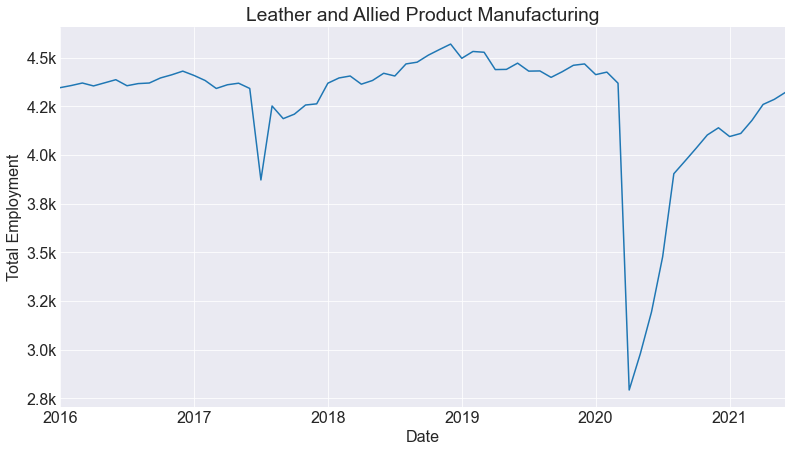

In [136]:
# plot series
s_leather = forecast_ind_dict['Leather and Allied Product Manufacturing']
s_leather.plot()
plt.gca().set(ylabel = 'Total Employment', title='Leather and Allied Product Manufacturing')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}k'.format(x / 1_000));

#### Recovery

In [137]:
# find min value where employment bottomed out and recovery started
s_leather[s_leather == s_leather.min()]

Date
2020-04-01    2792
Name: Total Employment, dtype: int64

In [138]:
# define train set for this model
# this slope was used since bounceback was so rapid
train = s_leather['2020-08' : ]

In [139]:
# Holts model
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)

# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    ]

future_index = pd.to_datetime(future_index_str)

holts = model.predict(start = future_index[0], end = future_index[-1])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Resumption

In [140]:
train = s_leather['2016' : '2018']
test = s_leather['2019']

In [141]:
forecast = train['2018'] + (train.diff(12).mean())
forecast.index = test.index

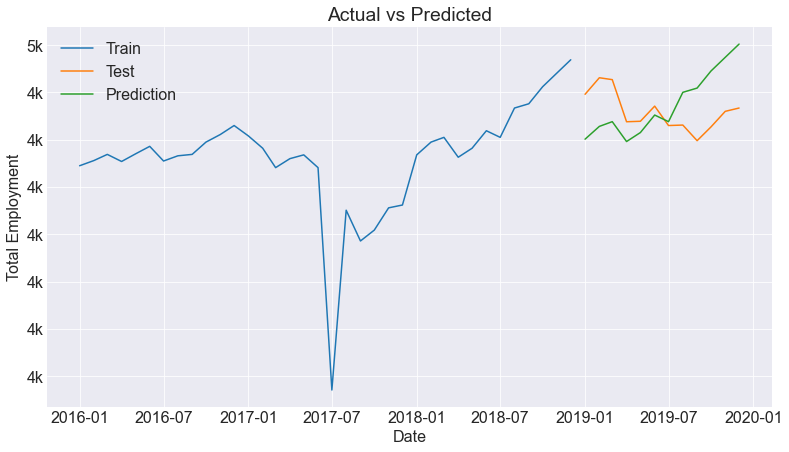

In [142]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [143]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

87.8485122874094

In [144]:
# get R^2
explained_variance_score(test, forecast)

-3.8274432467561565

In [145]:
# predict the future
historical = s_leather['2018-10' : '2019-12']

In [146]:
# get index for seasonal prediction
future_index_str = [
    '2021-10',
    '2021-11',
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12'
    ]

future_index = pd.to_datetime(future_index_str)

In [147]:
# make predictions
future = historical + (train.diff(12).mean())
# still need to reset the index
future.index = future_index

#### Final Plot

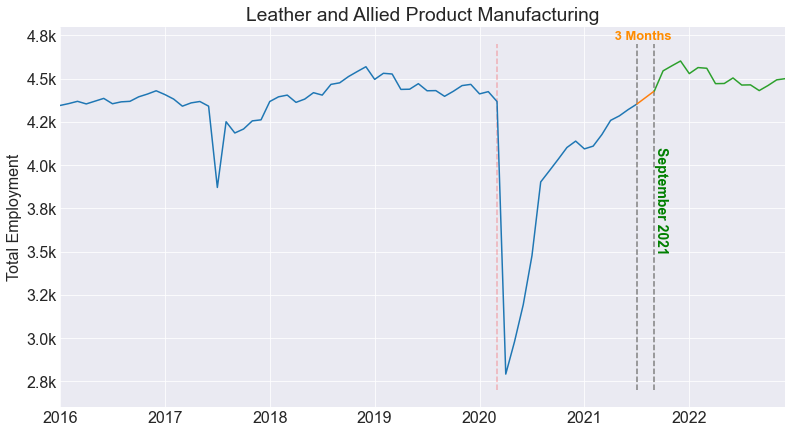

In [148]:
full_forecast = pd.concat([s_leather, holts, future])
full_forecast[ : '2021-07'].plot() # data we have
full_forecast['2021-07' : '2021-09'].plot() # linear recovery forecast
full_forecast['2021-09' : ].plot() # resumption forecast
plt.vlines(x='2021-07', ymin=2700, ymax=4700, linestyles='--', colors='gray')
plt.vlines(x='2021-09', ymin=2700, ymax=4700, linestyles='--', colors='gray')
plt.vlines(x='2020-03', ymin=2700, ymax=4700, linestyles='--', colors='red', alpha=0.25)
plt.text('2021-04', 4725, ' 3 Months', fontsize=13, color='darkorange', fontweight='bold')
plt.text('2021-09', 3500, 'September 2021', fontsize=14, color='green', fontweight='bold', rotation='-90')
plt.gca().set (title='Leather and Allied Product Manufacturing', ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}k'.format(x / 1_000));

---
## Months to Recovery
---

In [150]:
char_df = e.create_char_df_forecasting(forecast_ind_dict)

In [152]:
months_to_recovery = {
    'Motion Picture and Sound Recording Industries' : 25,
    'Performing Arts, Spectator Sports, and Related Industries' : 16,
    'Accommodation' : 26,
    'Clothing and Clothing Accessories Stores ' : 9,
    'Scenic and Sightseeing Transportation' : 13,
    'Amusement, Gambling, and Recreation Industries' : 3,
    'Personal and Laundry Services' : 9,
    'Miscellaneous Store Retailers ' : 7,
    'Furniture and Home Furnishings Stores ' : 7,
    'Food Services and Drinking Places' : 5,
    'Leather and Allied Product Manufacturing' : 3,
    'Sporting Goods, Hobby, Musical Instrument, and Book Stores ' : 0
}

In [153]:
char_df['months_to_recovery'] = char_df.index.map(months_to_recovery)

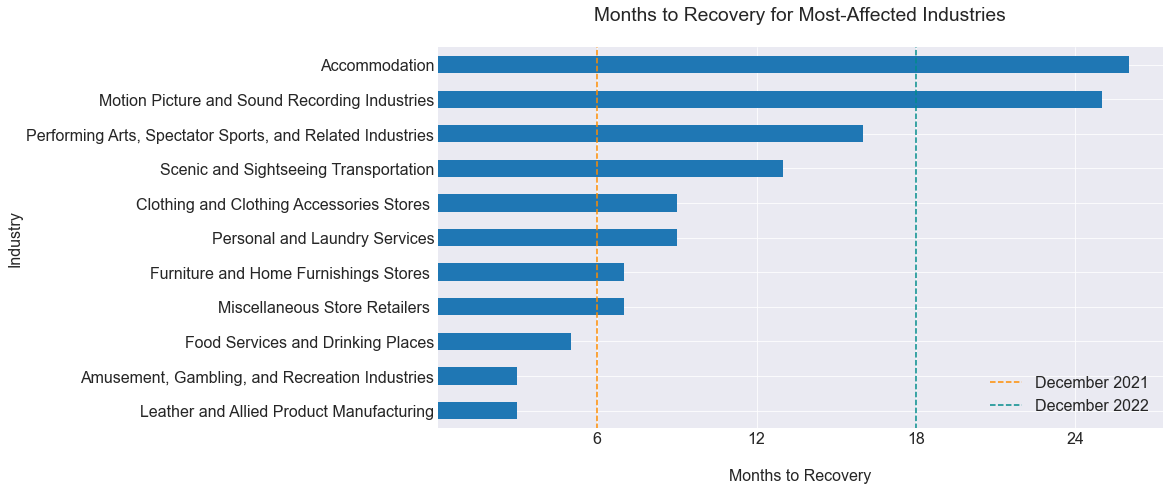

In [155]:
char_df.months_to_recovery.sort_values(ascending=True).drop('Sporting Goods, Hobby, Musical Instrument, and Book Stores ').plot.barh(label='')
plt.gca().set(ylabel='Industry', xlabel='\nMonths to Recovery', title='Months to Recovery for Most-Affected Industries\n');
plt.vlines(x=6, ymin=-1, ymax=12, linestyles='--', colors='darkorange', label='December 2021')
plt.vlines(x=18, ymin=-1, ymax=12, linestyles='--', colors='darkcyan', label='December 2022')
plt.xticks(ticks=[6,12,18,24]);
plt.legend(loc='lower right');